# **Hotdog vs Not a Hotdog CLASSIFICATION (KAGGLE DATASET)**

In this notebook, I have made an attempt to develop a CNN model from scratch to classify whether images contain either a hotdog or not a hotdog. The dataset for this notebook was taken from Kaggle.


Dataset Link:https://www.kaggle.com/tanliheng/hot-dog

Prediction Testing Link:https://www.kaggle.com/babychickoo/check-for-model-validation-hotdog-or-not

## Importing the Libraries

In [ ]:
import tensorflow as tf
import pandas as pd 
from keras.utils import to_categorical
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from glob import glob

## Data Preprocessing

In [ ]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Training Generator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=15)

training_set = train_datagen.flow_from_directory('../input/hot-dog/hotdog/train',
                                                 target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 2000 images belonging to 2 classes.


Testing Generator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('../input/hot-dog/hotdog/test',
                                            target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
                                            batch_size = 32,
                                            class_mode = 'binary',shuffle=False)

Found 800 images belonging to 2 classes.


## Building the CNN Model

In [ ]:
model = tf.keras.models.Sequential()

#Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, 
                                                                                 IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

#Adding a 2nd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

#Adding a 3rd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

## Fit the Model

In [ ]:
#Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#To prevent over fitting we will stop the learning after 10 epochs if val_loss value not decreased
earlystop = EarlyStopping(patience=10)

#Learning Rate Reduction
#We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
epochs=3 if FAST_RUN else 50
cnn = model.fit(
    x = training_set, validation_data = test_set, 
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 46s 727ms/step - loss: 0.5844 - accuracy: 0.7910 - val_loss: 10.5821 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 35s 563ms/step - loss: 0.4440 - accuracy: 0.8100 - val_loss: 10.5967 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 35s 561ms/step - loss: 0.4195 - accuracy: 0.8255 - val_loss: 1.3636 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 35s 548ms/step - loss: 0.3721 - accuracy: 0.8445 - val_loss: 0.7924 - val_accuracy: 0.5337
Epoch 5/50
63/63 [==============================] - 35s 557ms/step - loss: 0.3426 - accuracy: 0.8545 - val_loss: 0.6872 - val_accuracy: 0.6125
Epoch 6/50
63/63 [==============================] - 34s 547ms/step - loss: 0.3208 - accuracy: 0.8705 - val_loss: 0.5844 - val_accuracy: 0.6750
Epoch 7/50
63/63 [==============================] - 35s 559ms/step - loss: 0.3209 - accuracy: 0.8725 - val_loss: 0.6873 - val_accuracy: 0.64

## Visualize the model training by plotting Loss Function and Accuracy

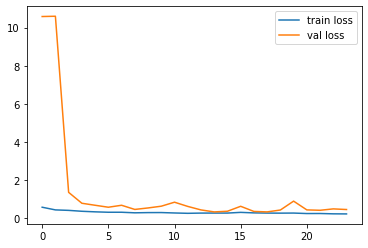

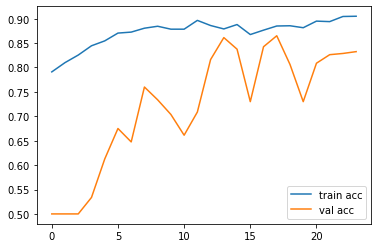

In [ ]:
# Plot the Loss Function
plt.plot(cnn.history['loss'], label='train loss')
plt.plot(cnn.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot the Accuracy
plt.plot(cnn.history['accuracy'], label='train acc')
plt.plot(cnn.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

## Model Prediction on images not found in train and test catalog

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../input/check-for-model-validation-hotdog-or-not/hot dog or not 2.jpg', 
                            target_size = (IMAGE_WIDTH, IMAGE_HEIGHT))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'Not a Hotdog'
else:
  prediction = ' Hotdog'

print(prediction)

Not a Hotdog


**'../input/check-for-model-validation-hotdog-or-not/hot dog or not 2.jpg' is Not a Hotdog's image**


**'../input/check-for-model-validation-hotdog-or-not/hot dog or not 1.jpg' is a Hotdog's image**

## **This CNN model which I have developed is providing me with accurate results on Prediction.**